### Preliminars

##### Imports

In [45]:
import sys
import preprocess
import sample
import cluster
import nn
import k_means
import fuzzy_c_means
import mountain
import regression
import visualize
import index
import SVM
import d_tree

import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
import os


%matplotlib widget
%reload_ext autoreload
%autoreload 2

np.random.seed(420)


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


image = "../images/"
table = "../tables/"


##### Read Data

In [46]:
dataset = 0
if dataset == 0:
    csv_file = "../data/pulsar_data_train.csv"
    csv_index, csv_header = None, 0
    csv_out = -1
    classify = True
elif dataset == 1:
    csv_file = "../data/IRIS.csv"
    csv_index, csv_header = 0, 0
    csv_out = -1
    classify = True
else:
    csv_file = '../data/examen.csv'
    csv_index, csv_header = None, None
    csv_out = -1
    classify = False

data, N_S, I_S = preprocess.get_data(csv_file, csv_header, csv_index)
X_S, Y_S, X_name, Y_name = preprocess.split_XY(data, csv_out)
X_S, Y_S, X_revert, Y_revert = preprocess.preprocess(X_S.T, Y_S.T, classify)


### Data Distribution

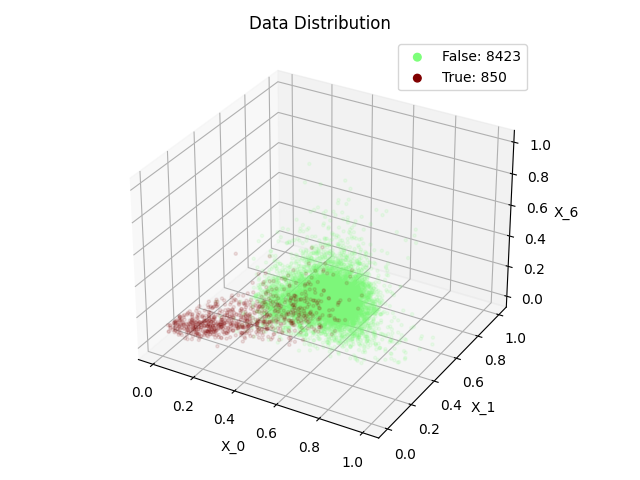

In [47]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, layout="tight")

visualize.cluster(ax, X_S[[0, 1, 6], :], Y_S, title="Data Distribution", axes_names=[
                  "X_0", "X_1", "X_6"], cluster_names=Y_revert, fuzzy=False)
fig.savefig(f"{image}dist.png", bbox_inches='tight')


# Sample

### PDF properties

In [48]:
pdf_info = sample.pdf_info(I_S)


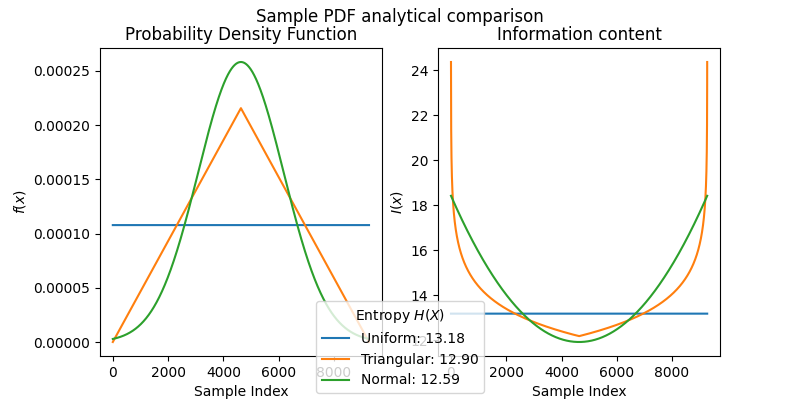

In [49]:
fig, ax = plt.subplots(1, 2, figsize=visualize.fig_size(1, 2))
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(I_S, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(I_S, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")
fig.savefig(f"{image}sample:info", bbox_inches='tight')


### Sampling data

In [50]:
pdf_sample = sample.sample(I_S)
partition_i = pdf_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in partition_i.items()}


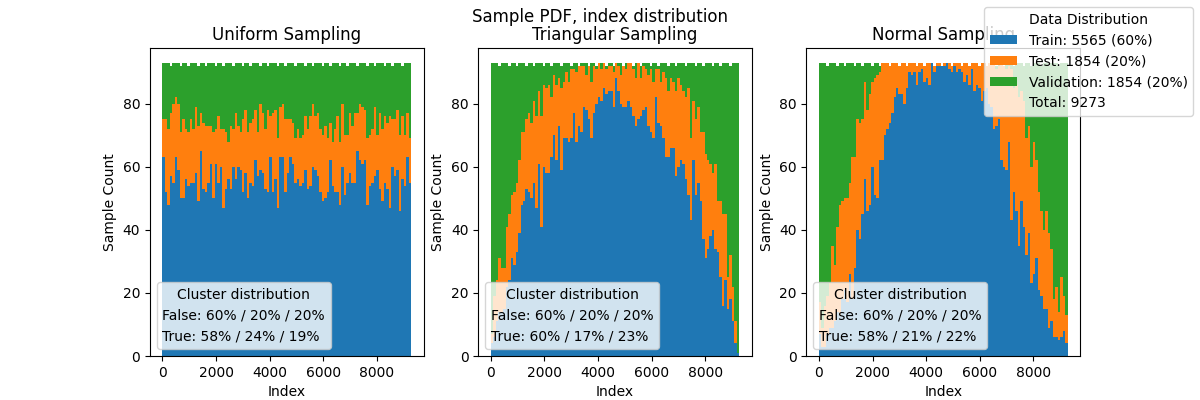

In [51]:
# Figure title
fig, ax = plt.subplots(1, 3, figsize=visualize.fig_size(1, 3))
fig.suptitle("Sample PDF, index distribution")
for ax_i, (pdf_name, pdf_partition) in zip(ax, pdf_sample.items()):
    ax_i.set_title(f"{pdf_name} Sampling")
    cluster.axis_labels(ax_i, 'Index', 'Sample Count')
    ax_i.hist(pdf_partition.values(), stacked=True, bins=100)
    if not cluster:
        continue
    legend = []

    for c in range(len(Y_revert)):
        legend_temp = []
        for partition_name, partition_index in pdf_partition.items():
            legend_temp.append(
                f"{np.sum(Y_S[c, partition_index])/np.sum(Y_S[c,:] == 1):.0%}")
        legend.append(f"{Y_revert[c]}: " + " / ".join(legend_temp))

    legend = ax_i.legend(legend, title="Cluster distribution",
                         loc="lower left", handlelength=0, handletextpad=0)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                     for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig(f"{image}sample:hist:index", bbox_inches='tight')


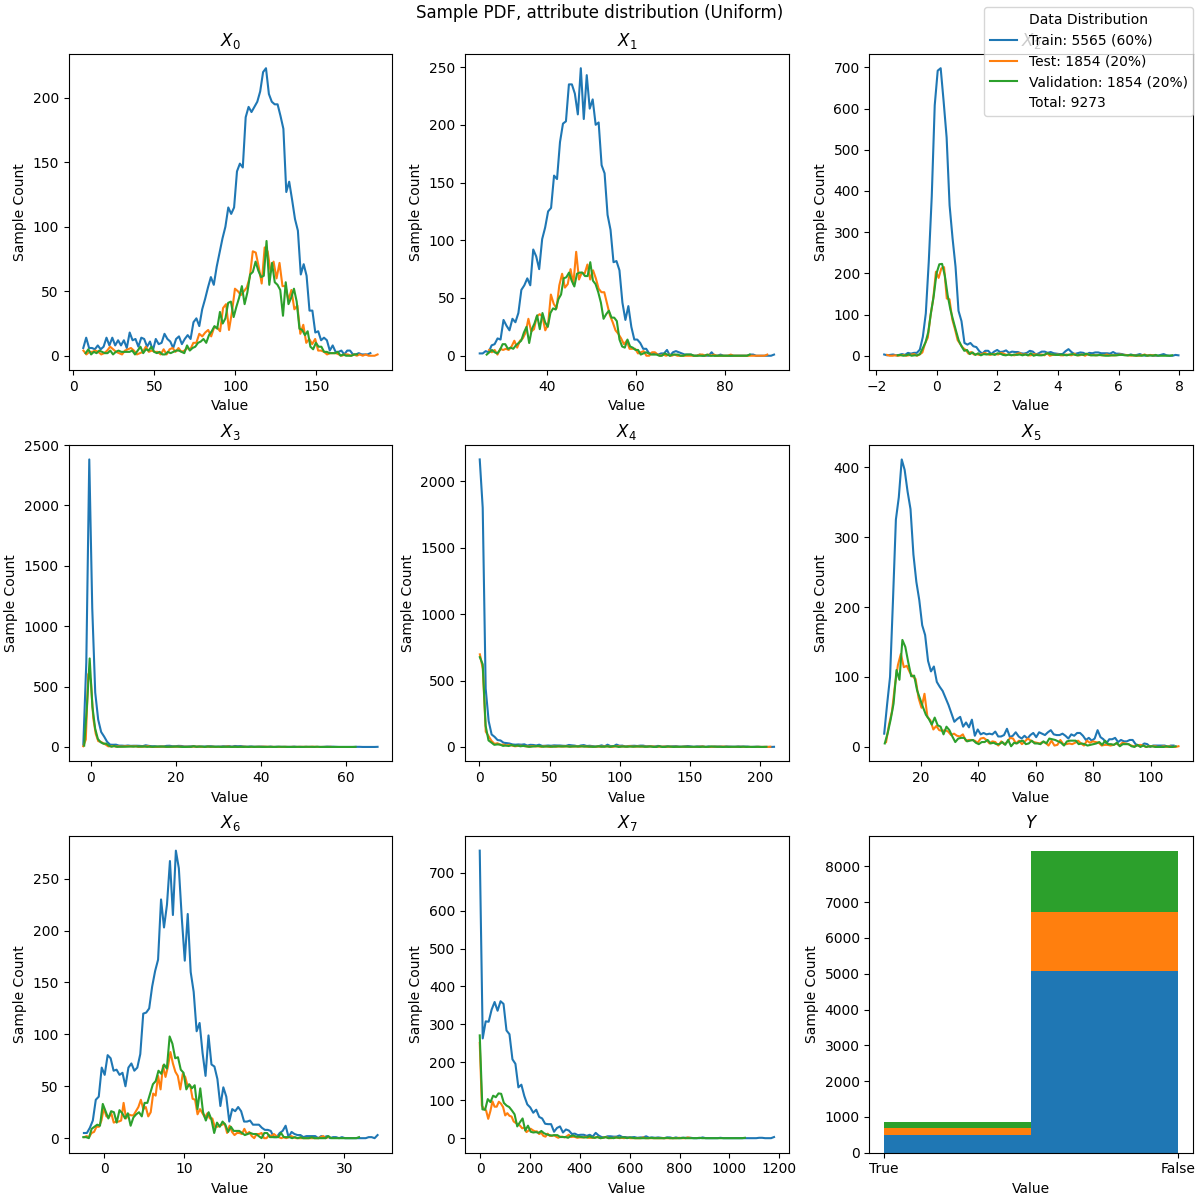

In [52]:

fig, ax = plt.subplots(3, 3, figsize=visualize.fig_size(
    3, 3), constrained_layout=True)
fig.suptitle(f"Sample PDF, attribute distribution (Uniform)")
for i in range(len(X_name)):
    ax_i = ax.flatten()[i]
    ax_i.set_title(f"$X_{i}$")
    cluster.axis_labels(ax_i, 'Value', 'Sample Count')
    for p in partition.values():
        yh, xh = np.histogram(X_revert(p[0])[i, :], bins=100)
        ax_i.plot(xh[:-1], yh)
i = 8
ax_i = ax.flatten()[i]
ax_i.set_title(f"$Y$")
cluster.axis_labels(ax_i, 'Value', 'Sample Count')
ax_i.hist([list(map(lambda x: Y_revert[x], np.argmax(p[1], axis=0)))
          for p in partition.values()], stacked=True, bins=2)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                    for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig(f"{image}sample:hist:variables", bbox_inches='tight')


# Supervised Learning

### Regression

In [53]:
U = dict(zip(partition.keys(), [{}, {}, {}]))

K = {
    "LinReg": regression.regression["Linear"],
    "LogReg": regression.regression["Logistic"]
}

    
for k_name, k in K.items():
    B, _ = regression.train(*partition["Train"], k)
    
    for i, (p_name, (X, Y)) in enumerate(partition.items()):
        U[p_name][k_name], U_reg = regression.eval(X, B, k)

### SVM

In [54]:
K = {
    "LinSVM": SVM.kernel["Linear"],
    "PolSVM": SVM.kernel["Polynomial"](2, 0),
    "RadSVM": SVM.kernel["Radial"](2)
}

C = {}
for k_name, k in K.items():
    W, alpha, cost = SVM.train(*partition["Train"],
                               epochs=100, tolerance=0.001, eta=0.0001, K=k)
    C[k_name] = cost
    for p_name, (X, Y) in partition.items():
        U[p_name][k_name] = SVM.eval(X, alpha, *partition["Train"], K=k)
        


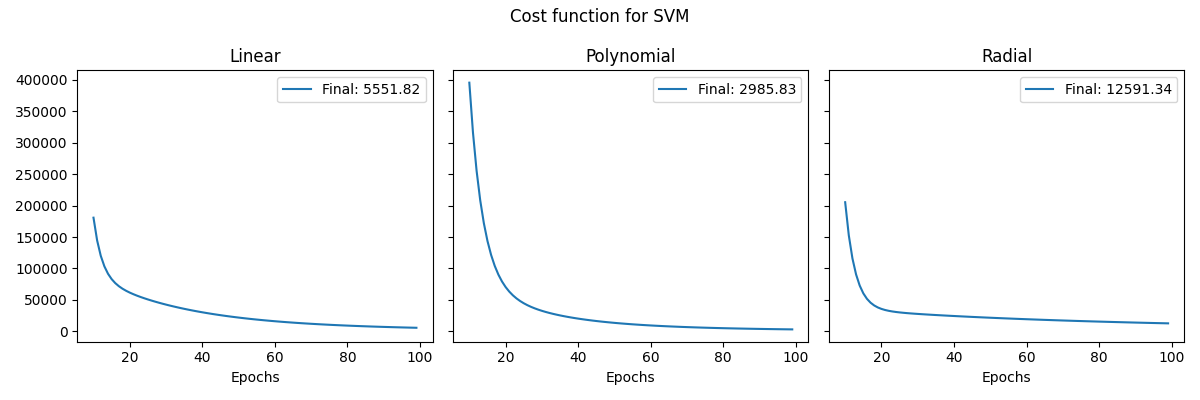

In [55]:
fig, ax = plt.subplots(1, len(K), figsize=visualize.fig_size(1, len(K)), 
    sharey=True, layout = "tight")
fig.suptitle("Cost function for SVM")
for i, (k_name, cost) in enumerate(C.items()):
    ax[i].plot(range(10, len(cost)), cost[10:],
        label=f"Final: {cost[-1]:.2f}")
    ax[i].legend()
    ax[i].set_xlabel("Epochs")
    ax[i].set_title(list(SVM.kernel.keys())[i])
fig.savefig(f"{image}svn:cost.png")


### Decision Trees

In [56]:
def one(p_name): return np.ones(partition[p_name][0].shape[1]) == 1

T = d_tree.train(*partition["Train"], one("Train"))
for p_name, (X, Y) in partition.items():
    U_tree = d_tree.eval(partition[p_name][0], T, one(p_name))[None, :]
    U_tree = np.concatenate([U_tree, ~U_tree], axis=0)


### Neural Network

In [57]:
epochs = 2500
neurons = np.array(range(5))+1
layers = np.array(range(3))+1
eta = [0.2, 0.5, 0.9]

nn_metric = {
    "grad:min": (np.inf, None, None),
    "grad:max": (-np.inf, None, None),
    "err:min": (np.inf, None, None),
    "err:max": (-np.inf, None, None)
}

for params in iter.product(neurons, layers, eta):
    c_neurons, c_layers, c_eta = params
    print(params, end="\r")
    with HiddenPrints():
        W, B, delta_nn, E_nn = nn.train(partition["Train"],
            hidden=[c_neurons] * c_layers, classify=classify, test_set=partition,
            epochs=epochs, tolerance=0.000001, eta=c_eta)
    grad = np.sum(delta_nn[-1])
    err = np.sum([e[-1] for e in E_nn.values()])

    if grad < nn_metric["grad:min"][0]:
        nn_metric["grad:min"] = (grad, params, (W, B, delta_nn, E_nn))
    if grad > nn_metric["grad:max"][0]:
        nn_metric["grad:max"] = (grad, params, (W, B, delta_nn, E_nn))
    if err < nn_metric["err:min"][0]:
        nn_metric["err:min"] = (err, params, (W, B, delta_nn, E_nn))
    if err > nn_metric["err:max"][0]:
        nn_metric["err:max"] = (err, params, (W, B, delta_nn, E_nn))


In [58]:
for p_name, (X, Y) in partition.items():
    grad, params, (W, B, delta_nn, E_nn) = nn_metric["err:min"]
    U[p_name]["NNErr"], _ = nn.eval(X, W, B, classify=True)
    grad, params, (W, B, delta_nn, E_nn) = nn_metric["grad:min"]
    U[p_name]["NNGrad"], _ = nn.eval(X, W, B, classify=True)

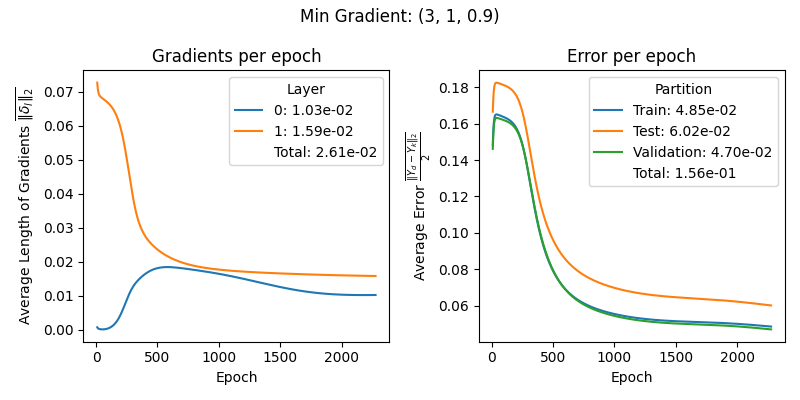

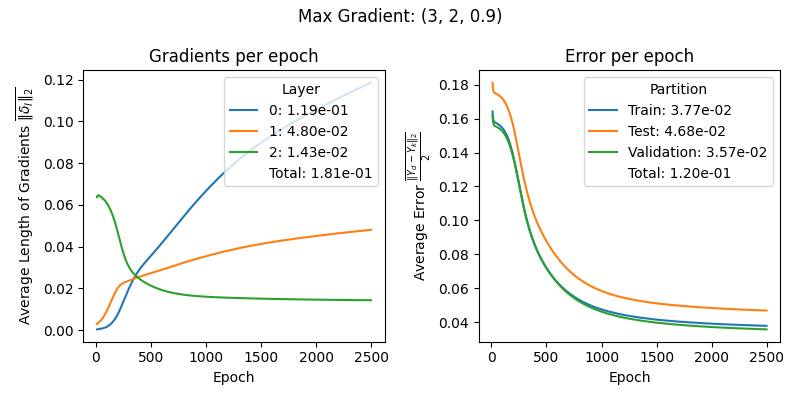

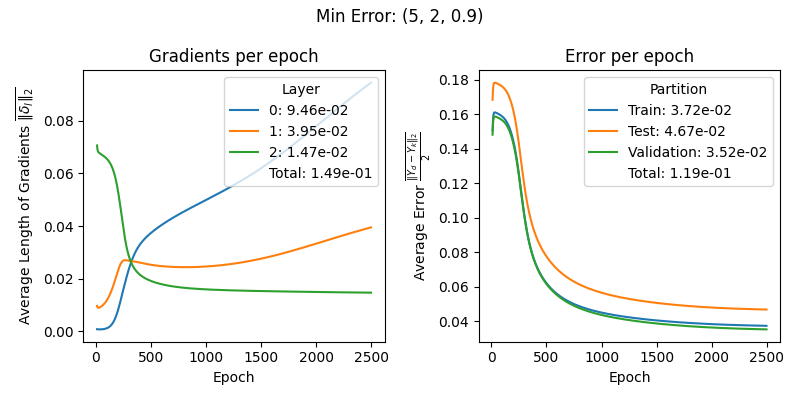

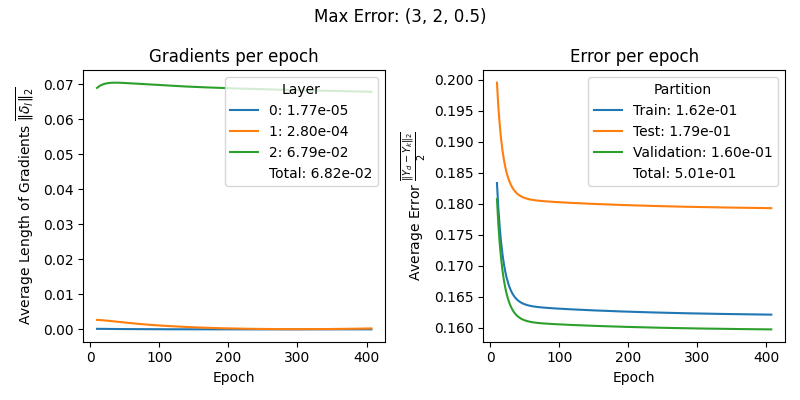

In [59]:
skip = 10
nn_title = {
    "grad:min": "Min Gradient",
    "grad:max": "Max Gradient",
    "err:min": "Min Error",
    "err:max": "Max Error"
}
for name, (value, (neurons, layers, eta), ((W, B, delta_nn, E_nn))) in nn_metric.items():
    fig, ax = plt.subplots(1, 2, figsize= visualize.fig_size(1, 2), layout="tight")
    fig.suptitle(f"{nn_title[name]}: {neurons, layers, eta}")
    ax[0].set_title("Gradients per epoch")
    ax[0].plot(range(skip, len(delta_nn)), delta_nn[skip:],
               label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
    ax[0].plot([], [], label=f"Total: {np.sum(delta_nn[-1]):.2e}")
    legend = ax[0].legend(title="Layer", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[0], "Epoch",
                        "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

    ax[1].set_title("Error per epoch")
    for p_name in E_nn.keys():
        ax[1].plot(range(skip, len(E_nn[p_name])), E_nn[p_name][skip:],
                   label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
    ax[1].plot(
        [], [], label=f"Total: {np.sum([e[-1] for e in E_nn.values()]):.2e}")
    legend = ax[1].legend(title="Partition", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[1], "Epoch",
                        "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")
    fig.savefig(f"{image}nn:{name}.png", bbox_inches='tight')


In [60]:
for name, (value, (neurons, layers, eta), (W, B, delta_nn, E_nn)) in nn_metric.items():
    print(name, end="\r")
    with HiddenPrints():
        W, B, delta_nn2, E_nn2 = nn.train(partition["Train"], W=W, B=B,
            hidden=[neurons] * layers, classify=classify, test_set=partition,
            epochs=epochs, eta=c_eta, tolerance=0.000001)
    delta_nn.extend(delta_nn2)
    for k in E_nn:
        E_nn[k].extend(E_nn2[k])
    grad = np.sum(delta_nn[-1])
    err = np.sum([e[-1] for e in E_nn.values()])

    if name == "grad:min":
        nn_metric[name] = (grad, params, (W, B, delta_nn, E_nn))
    elif name == "grad:max":
        nn_metric[name] = (grad, params, (W, B, delta_nn, E_nn))
    elif name == "err:min":
        nn_metric[name] = (err, params, (W, B, delta_nn, E_nn))
    elif name == "err:max":
        nn_metric[name] = (err, params, (W, B, delta_nn, E_nn))


# Unsupervised Learning

### Mountain Clustering

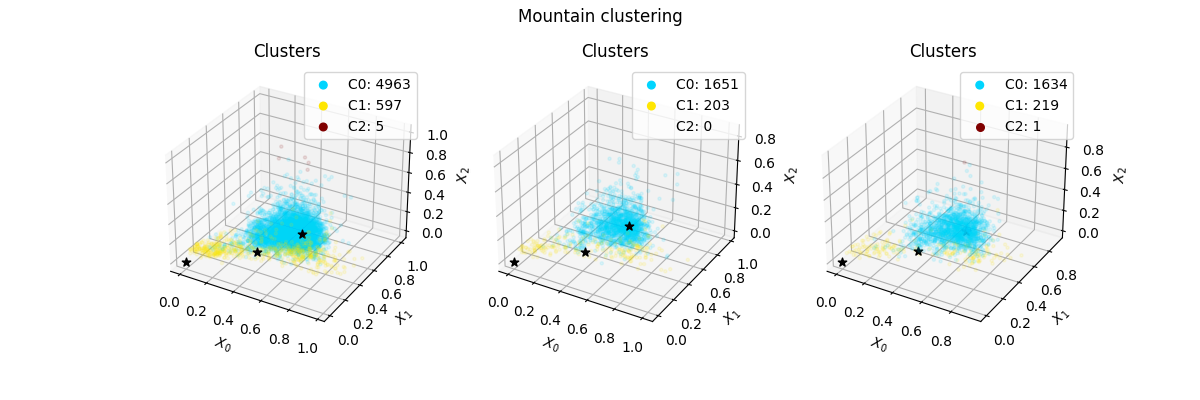

In [109]:
n = int(10**(5/X_S.shape[0]))
C = mountain.train(partition["Train"][0], 1, 1, n=n, epsilon=50)

fig, ax = plt.subplots(1,3, figsize=visualize.fig_size(1,3), subplot_kw={"projection": "3d"})
fig.suptitle("Mountain clustering")

for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["MtnCluster"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6],:], U[p_name]["MtnCluster"], C=C)

fig.savefig(f"{image}mountain.png")
k_mountain = C.shape[1]

### Substractive Clustering

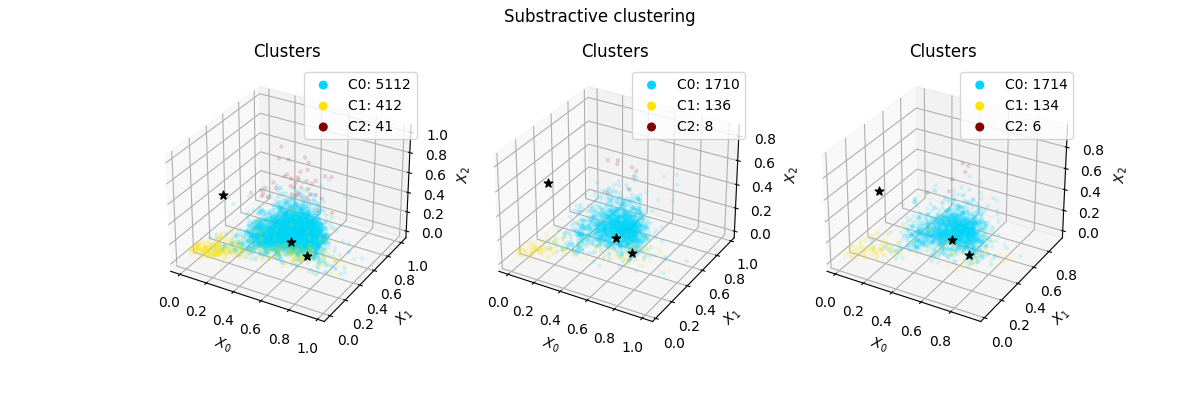

In [115]:
C = mountain.train(partition["Train"][0], 1, 1, 50, substractive=True)

fig, ax = plt.subplots(1,3, figsize=visualize.fig_size(1,3), subplot_kw={"projection": "3d"})
fig.suptitle("Substractive clustering")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["SubCluster"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6],:], U[p_name]["SubCluster"], C=C)

fig.savefig(f"{image}substractive.png")

k_subs = int(C.shape[1])

### K-Means

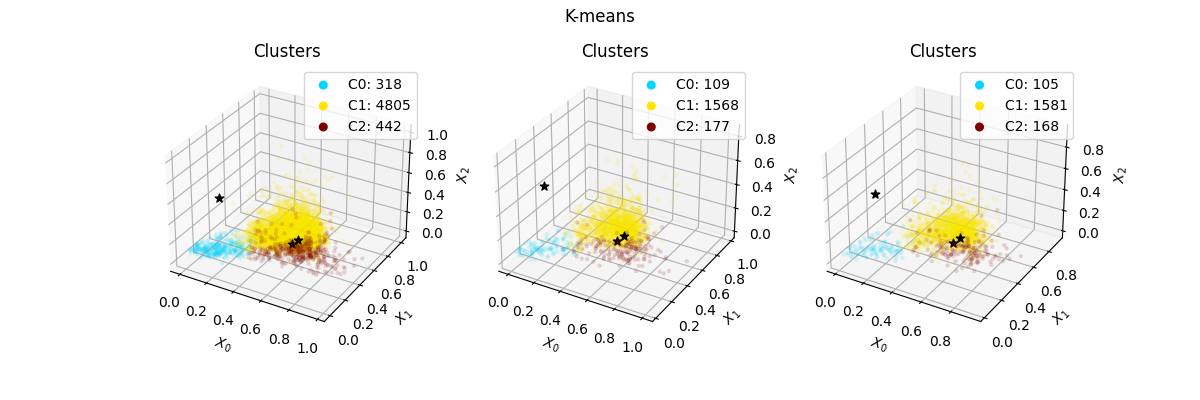

In [111]:
_, C = k_means.train(partition["Train"][0], k_mountain, 0.00001)

fig, ax = plt.subplots(1,3, figsize=visualize.fig_size(1,3), subplot_kw={"projection": "3d"})
fig.suptitle("K-means")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["Kmeans"] = k_means.eval(X, C)
    visualize.cluster(ax[i], X[[0, 1, 6],:], U[p_name]["Kmeans"], C=C)

fig.savefig(f"{image}kmeans.png")

### Fuzzy C-means

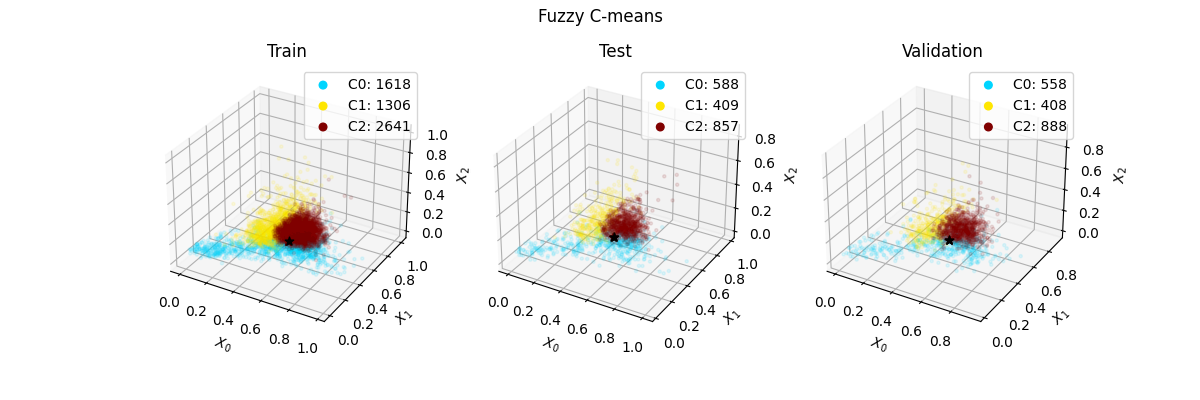

In [116]:
m = 5
_, C = fuzzy_c_means.train(k_subs, partition["Train"][0], m, 0.002)

fig, ax = plt.subplots(1,3, figsize=visualize.fig_size(1,3), subplot_kw={"projection": "3d"})
fig.suptitle("Fuzzy C-means")
for i, (p_name, (X, Y)) in enumerate(partition.items()):
    U[p_name]["FuzzyC"] = fuzzy_c_means.eval(X, C, m)
    visualize.cluster(ax[i], X[[0, 1, 6],:], U[p_name]["FuzzyC"], title=p_name, C=C)
fig.savefig(f"{image}fuzzycmeans.png")

In [113]:
for p_name, (X, Y) in partition.items():
    U_table = index.eval(U[p_name], Y)
    U_table[0,0] = ""
    for i in range(1,U_table.shape[0]):
        for j in range(1,U_table.shape[1]):
            U_table[i, j] = f"{U_table[i, j]:.2f}"
    np.savetxt(f"{table}index:{p_name.lower()}.csv", U_table, delimiter=",", fmt='%s')